# Zero-Shot Classification

## Overview
In this setup, we use a vision-language model named CLIP, that is trained on large internet scale data (~400 million image-text pairs). This model is trained with language prompts, meaning we can use language to ask the model questions.

We can show it an image, and a set of text prompts to which the model will select and return the matching text prompt. E.g. we give a photo of a cat & labels {cat, dog, bird, car}. The model will select dog as the correct label.

These kind of models can be very useful to work with in tasks where you do not want to perform any training. Also, these models can be fine-tuned on a specific dataset using the same linear probing strategy we tried out earlier.

## Exercise
In this exercise, we focus on zero-shot classification using CLIP. Fine-tuning under linear probe settings is left as an exercise for anyone interested.

In [2]:
import torch
import torchvision

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0r4gw9zp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0r4gw9zp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=4ce45a45f778cdfd2d0910a306b2e53f9cbae640d3248aee0b8720d56a753068
  Stored in directory: /tmp/pip-ephem-wheel-cache-662q3pr2/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [3]:
! mkdir datasets
! ls

mkdir: cannot create directory ‘datasets’: File exists
 cifar_net.pth	 Part-1-Pytorch_Training_Pipeline.ipynb  'Week 2.pdf'
 data		 Part-2-Transfer-Learning.ipynb
 datasets	 Part-3-Zero-shot.ipynb


In [5]:
ds_train = torchvision.datasets.OxfordIIITPet(root="datasets", split="trainval", download=True)
ds_val = torchvision.datasets.OxfordIIITPet(root="datasets", split="test", download=True)

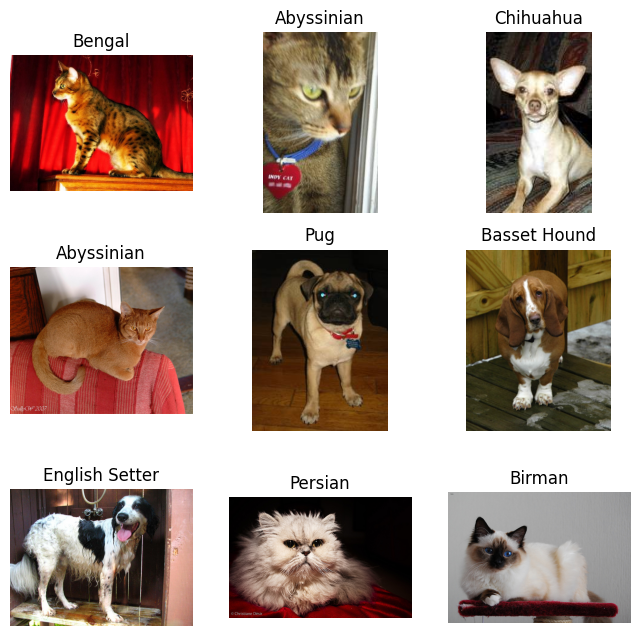

In [6]:
# let's first look at the data again
from matplotlib import pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds_train), size=(1,)).item()
    img, label = ds_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ds_train.classes[label])
    plt.axis("off")
    plt.imshow(np.array(img))
plt.show()

In [7]:
# load the CLIP model

import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [09:51<00:00, 599kiB/s]


In [8]:
for name, idx in ds_train.class_to_idx.items():
    assert ds_train.classes[idx] == name

In [9]:
ds_train.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [10]:
# convert all labels to embeddings
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of pet.") for c in ds_train.classes]).to(device)
# text_inputs = torch.cat([clip.tokenize(f"{c}, photo dog pet of a type a a .") for c in ds_train.classes]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_inputs.shape)

torch.Size([37, 77])


In [11]:
text_features.shape

torch.Size([37, 512])

In [12]:
# process one image

sample_idx = 1205
img, label = ds_train[sample_idx]

image = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

In [13]:
image_features.shape

torch.Size([1, 512])

Prediction for class Pomeranian: Pomeranian


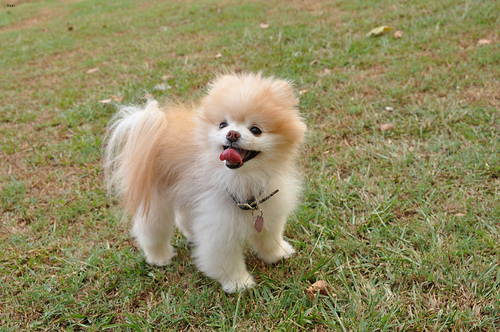

In [14]:
# let's see our prediction

gt_annotation = ds_train.classes[label]
prediction = ds_train.classes[indices[0].item()]

print(f"Prediction for class {gt_annotation}: {prediction}")
img

In [15]:
# now let's run an entire evaluation

def test_model(dataset, model, text_features, verbose=False):
    size = len(dataset)
    correct = 0
    count = 0
    print(f"Running evaluation on {size} samples.")
    with torch.no_grad():
        for idx, (X, y) in enumerate(dataset):
            image = preprocess(X).unsqueeze(0).to(device)
            with torch.no_grad():
              image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)
            correct += (indices[0].item() == y)
            count += 1
            if verbose and idx % 100 == 0:
              print(100 * correct / count)

    correct /= size
    return correct

In [16]:
acc = test_model(ds_val, model, text_features, verbose=False)
print(f"CLIP acc on model: {acc * 100:.2f}")

Running evaluation on 3669 samples.
CLIP acc on model: 87.46
